In [1]:
import pandas as pd
import numpy as np

# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

Note: do not import matplotlib here so you can use n_jobs > 1 later.

### Data cleaning and exploration

In [2]:
bb = pd.read_csv('/Volumes/My_Passport/MILB/pitchdata.csv')

In [3]:
bb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62577 entries, 0 to 62576
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GameID        62577 non-null  object 
 1   PitchNumber   62577 non-null  int64  
 2   Balls         62577 non-null  int64  
 3   Strikes       62577 non-null  int64  
 4   PitcherHand   62577 non-null  object 
 5   BatSide       62577 non-null  object 
 6   PlateHeight   62466 non-null  float64
 7   PlateSide     62466 non-null  float64
 8   CalledStrike  62577 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 4.3+ MB


So few NaN values that it makes most sense to drop them. They also occur in the same observations, so we are only losing 111 observations total.

In [4]:
bb = bb.dropna()

In [5]:
bb.describe()

,PitchNumber,Balls,Strikes,PlateHeight,PlateSide,CalledStrike
count,62466.000000,62466.000000,62466.000000,62466.000000,62466.000000,62466.000000
mean,145.150754,0.763231,0.729981,2.281051,-0.060027,0.313050
std,86.583364,0.931636,0.803086,1.160840,0.990611,0.463738
min,1.000000,0.000000,0.000000,-3.641154,-4.410613,0.000000
25%,71.000000,0.000000,0.000000,1.462439,-0.802473,0.000000
50%,142.000000,0.000000,1.000000,2.231538,-0.077484,0.000000
75%,214.000000,1.000000,1.000000,3.114517,0.680923,1.000000
max,370.000000,3.000000,2.000000,9.177937,5.231591,1.000000


Check balance of two classes:

In [6]:
bb.CalledStrike.value_counts()

0    42911
1    19555
Name: CalledStrike, dtype: int64

What is this GameID column and is it useful or necessary?

In [7]:
bb.GameID.value_counts()

A45A3595-1E4A-4562-A574-FB813D1A2662    217
D70DE0BE-7191-421B-A064-423F4B7DFE7F    216
668A001C-5745-4513-86C8-C68FDA27B12C    212
B58A2337-E436-4D3B-AF69-C761038901B3    211
93E3EBB1-9297-4A1A-BDB0-1635A3C58432    211
                                       ... 
FEB732DD-0DEE-4ABB-BF44-78147A3CDD50     92
C82FB446-7FD8-4AC9-A644-775936F96739     92
B5F40BB6-066A-42FC-ACF8-A50FCE2B60A9     91
0756AE21-05F2-411C-9913-78B121273E76     87
51D4BEEF-B226-40D7-A7D5-B9EC99ACFAEC     77
Name: GameID, Length: 404, dtype: int64

Turn batter and pitcher side/hand to dummy columns, create a new feature describing if the pitcher and batter have the same dominant hand, then drop the original PitcherHand and BatSide columns.

In [8]:
bb['dummy_PitcherRighty'] = pd.get_dummies(bb.PitcherHand,drop_first=True)
bb['dummy_BatterRighty'] = pd.get_dummies(bb.BatSide,drop_first=True)

bb['same_handedness'] = bb.PitcherHand == bb.BatSide

bb = bb.drop(columns = ['PitcherHand','BatSide'])

In [9]:
# bb = bb.reset_index(drop=True)

### Data analysis
#### Using all features
Split data into dependent and independent variables.

In [10]:
y = bb.CalledStrike
X = bb[['Balls','Strikes','PlateHeight','PlateSide','dummy_PitcherRighty','dummy_BatterRighty','same_handedness']]

Imports for various samplers and scalers. Also, encode the GameID column to an ordinal signifying group number using pd.factorize(). Could have used OrdinalEncoder from sklearn.preprocessing here also.

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV,GroupKFold, GridSearchCV

sc = StandardScaler()
minmaxsc = MinMaxScaler()
maxabssc = MaxAbsScaler()
pt = PowerTransformer()
gkf = GroupKFold(5)
groups,ids_ = pd.factorize(bb.GameID)

Split data into train and test sets along group lines using GroupKFold. Had previously chosen 5 folds for cross-validation, so here it performs the first split and then breaks the for loop. The X_te and y_te are the test set, while the X_tr and y_tr are the train, which will later be split again for 5-fold cross-validation.

In [12]:
for tr,te in gkf.split(X,y,groups):
    X_tr,X_te = X.iloc[tr],X.iloc[te]
    y_tr,y_te = y.iloc[tr],y.iloc[te]
    break

# X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,random_state=87)

Could run this to look at each feature's individual influence on the two classes. This would require importing seaborn earlier.

In [13]:
# sns.pairplot(x_train.join(y_train),'CalledStrike')

In [14]:
from imblearn.under_sampling import RandomUnderSampler,TomekLinks,NearMiss
from imblearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedRandomForestClassifier,EasyEnsembleClassifier

from xgboost import XGBClassifier

Using TensorFlow backend.
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/User

Create dictionaries to hold the results from RandomizedSearchCV. I'd employed the BalancedRandomForestClassifier originally as I was only looking at the RandomUnderSampler, which is built into that class. When I started using other undersampling techniques, however, I could not find how to specify those when instantiating the bal_rf class, so I ended up just balancing the classes with the sampler of interest prior to any model training. I think this means I could have used the regular RandomForestClassifier from sklearn.forest instead.

Also, the number of iterations for the random search is probably a little high - I'd been varying more parameters in each of the classifiers before. Current parameters having it operate as more of a GridSearchCV.

In [15]:
knn = KNeighborsClassifier(n_jobs=-1)
k_range = range(1,21)

bal_rf = BalancedRandomForestClassifier(random_state=87,n_jobs=-1)
n_estimators = range(50,201,50)
depth_range= range(1,21)

xg = XGBClassifier(random_state=87,n_jobs=-1)
lr = np.arange(.1,1.1,.1)

ens = EasyEnsembleClassifier(random_state=87,n_jobs=-1)
n_estimators2 = range(10,61,10)

clf_sc_rus = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_sc_tom = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_sc_nm1 = {}.fromkeys(['knn','bal_rf','xg','ens'])

rus = RandomUnderSampler(random_state=87)
tom = TomekLinks(random_state=87,n_jobs=-1)
nm1 = NearMiss(random_state=87,version=1,n_jobs=-1)

clf_sc_rus['knn'] = {'sampler':rus,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_sc_rus['bal_rf'] = {'sampler':rus,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_sc_rus['xg'] = {'sampler':rus,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_sc_rus['ens'] = {'sampler':rus,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_sc_rus:
    pipe = make_pipeline(sc,clf_sc_rus[model]['sampler'],clf_sc_rus[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_sc_rus[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_sc_rus[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})

    
clf_sc_tom['knn'] = {'sampler':[tom,rus],'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_sc_tom['bal_rf'] = {'sampler':[tom,rus],'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_sc_tom['xg'] = {'sampler':[tom,rus],'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_sc_tom['ens'] = {'sampler':[tom,rus],'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_sc_tom:
    pipe = make_pipeline(sc,clf_sc_tom[model]['sampler'][0],clf_sc_tom[model]['sampler'][1],clf_sc_tom[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_sc_tom[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_sc_tom[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})


clf_sc_nm1['knn'] = {'sampler':nm1,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_sc_nm1['bal_rf'] = {'sampler':nm1,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_sc_nm1['xg'] = {'sampler':nm1,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_sc_nm1['ens'] = {'sampler':nm1,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_sc_nm1:
    pipe = make_pipeline(sc,clf_sc_nm1[model]['sampler'],clf_sc_nm1[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_sc_nm1[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_sc_nm1[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})


/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_sear

Originally had just tried the StandardScaler and RandomUnderSampler, but subsequent trials of other undersamplers (above) and later, other scalers, showed slight improvements in the best score.

In [16]:
for clf in [clf_sc_rus,clf_sc_tom,clf_sc_nm1]:
    for model in clf:
        print(model,clf[model]['sampler'].__class__,clf[model]['best_score_'])

knn <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8328379814654582
bal_rf <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8033866618596532
xg <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8006467015331991
ens <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7920955149307556
knn <class 'list'> 0.815145658561987
bal_rf <class 'list'> 0.7918398026300881
xg <class 'list'> 0.7897039035437357
ens <class 'list'> 0.7769981767601604
knn <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8604478658112913
bal_rf <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8398423822372375
xg <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8564177838084595
ens <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'

I reran the cells above swapping out StandardScaler for MinMaxScaler, MaxAbsScaler, and PowerTransformer, changing the variable names accordingly.

In [18]:
knn = KNeighborsClassifier(n_jobs=-1)
k_range = range(1,21)

bal_rf = BalancedRandomForestClassifier(random_state=87,n_jobs=-1)
n_estimators = range(50,201,50)
depth_range= range(1,21)

xg = XGBClassifier(random_state=87,n_jobs=-1)
lr = np.arange(.1,1.1,.1)

ens = EasyEnsembleClassifier(random_state=87,n_jobs=-1)
n_estimators2 = range(10,61,10)

clf_ptsc_rus = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_ptsc_tom = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_ptsc_nm1 = {}.fromkeys(['knn','bal_rf','xg','ens'])

rus = RandomUnderSampler(random_state=87)
tom = TomekLinks(random_state=87,n_jobs=-1)
nm1 = NearMiss(random_state=87,version=1,n_jobs=-1)

clf_ptsc_rus['knn'] = {'sampler':rus,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_ptsc_rus['bal_rf'] = {'sampler':rus,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_ptsc_rus['xg'] = {'sampler':rus,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_ptsc_rus['ens'] = {'sampler':rus,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_ptsc_rus:
    pipe = make_pipeline(pt,clf_ptsc_rus[model]['sampler'],clf_ptsc_rus[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_ptsc_rus[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_ptsc_rus[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})

    
clf_ptsc_tom['knn'] = {'sampler':[tom,rus],'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_ptsc_tom['bal_rf'] = {'sampler':[tom,rus],'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_ptsc_tom['xg'] = {'sampler':[tom,rus],'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_ptsc_tom['ens'] = {'sampler':[tom,rus],'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_ptsc_tom:
    pipe = make_pipeline(pt,clf_ptsc_tom[model]['sampler'][0],clf_ptsc_tom[model]['sampler'][1],clf_ptsc_tom[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_ptsc_tom[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_ptsc_tom[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})


clf_ptsc_nm1['knn'] = {'sampler':nm1,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_ptsc_nm1['bal_rf'] = {'sampler':nm1,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_ptsc_nm1['xg'] = {'sampler':nm1,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_ptsc_nm1['ens'] = {'sampler':nm1,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_ptsc_nm1:
    pipe = make_pipeline(pt,clf_ptsc_nm1[model]['sampler'],clf_ptsc_nm1[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_ptsc_nm1[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_ptsc_nm1[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})
    

/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [20]:
knn = KNeighborsClassifier(n_jobs=-1)
k_range = range(1,21)

bal_rf = BalancedRandomForestClassifier(random_state=87,n_jobs=-1)
n_estimators = range(50,201,50)
depth_range= range(1,21)

xg = XGBClassifier(random_state=87,n_jobs=-1)
lr = np.arange(.1,1.1,.1)

ens = EasyEnsembleClassifier(random_state=87,n_jobs=-1)
n_estimators2 = range(10,61,10)

clf_minmaxsc_rus = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_minmaxsc_tom = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_minmaxsc_nm1 = {}.fromkeys(['knn','bal_rf','xg','ens'])

rus = RandomUnderSampler(random_state=87)
tom = TomekLinks(random_state=87,n_jobs=-1)
nm1 = NearMiss(random_state=87,version=1,n_jobs=-1)

clf_minmaxsc_rus['knn'] = {'sampler':rus,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_minmaxsc_rus['bal_rf'] = {'sampler':rus,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_minmaxsc_rus['xg'] = {'sampler':rus,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_minmaxsc_rus['ens'] = {'sampler':rus,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_minmaxsc_rus:
    pipe = make_pipeline(minmaxsc,clf_minmaxsc_rus[model]['sampler'],clf_minmaxsc_rus[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_minmaxsc_rus[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_minmaxsc_rus[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})

    
clf_minmaxsc_tom['knn'] = {'sampler':[tom,rus],'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_minmaxsc_tom['bal_rf'] = {'sampler':[tom,rus],'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_minmaxsc_tom['xg'] = {'sampler':[tom,rus],'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_minmaxsc_tom['ens'] = {'sampler':[tom,rus],'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_minmaxsc_tom:
    pipe = make_pipeline(minmaxsc,clf_minmaxsc_tom[model]['sampler'][0],clf_minmaxsc_tom[model]['sampler'][1],clf_minmaxsc_tom[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_minmaxsc_tom[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_minmaxsc_tom[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})


clf_minmaxsc_nm1['knn'] = {'sampler':nm1,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_minmaxsc_nm1['bal_rf'] = {'sampler':nm1,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_minmaxsc_nm1['xg'] = {'sampler':nm1,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_minmaxsc_nm1['ens'] = {'sampler':nm1,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_minmaxsc_nm1:
    pipe = make_pipeline(minmaxsc,clf_minmaxsc_nm1[model]['sampler'],clf_minmaxsc_nm1[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_minmaxsc_nm1[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_minmaxsc_nm1[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})
    

/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_sear

In [21]:
knn = KNeighborsClassifier(n_jobs=-1)
k_range = range(1,21)

bal_rf = BalancedRandomForestClassifier(random_state=87,n_jobs=-1)
n_estimators = range(50,201,50)
depth_range= range(1,21)

xg = XGBClassifier(random_state=87,n_jobs=-1)
lr = np.arange(.1,1.1,.1)

ens = EasyEnsembleClassifier(random_state=87,n_jobs=-1)
n_estimators2 = range(10,61,10)

clf_maxabssc_rus = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_maxabssc_tom = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_maxabssc_nm1 = {}.fromkeys(['knn','bal_rf','xg','ens'])

rus = RandomUnderSampler(random_state=87)
tom = TomekLinks(random_state=87,n_jobs=-1)
nm1 = NearMiss(random_state=87,version=1,n_jobs=-1)

clf_maxabssc_rus['knn'] = {'sampler':rus,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_maxabssc_rus['bal_rf'] = {'sampler':rus,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_maxabssc_rus['xg'] = {'sampler':rus,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_maxabssc_rus['ens'] = {'sampler':rus,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_maxabssc_rus:
    pipe = make_pipeline(maxabssc,clf_maxabssc_rus[model]['sampler'],clf_maxabssc_rus[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_maxabssc_rus[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_maxabssc_rus[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})

    
clf_maxabssc_tom['knn'] = {'sampler':[tom,rus],'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_maxabssc_tom['bal_rf'] = {'sampler':[tom,rus],'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_maxabssc_tom['xg'] = {'sampler':[tom,rus],'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_maxabssc_tom['ens'] = {'sampler':[tom,rus],'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_maxabssc_tom:
    pipe = make_pipeline(maxabssc,clf_maxabssc_tom[model]['sampler'][0],clf_maxabssc_tom[model]['sampler'][1],clf_maxabssc_tom[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_maxabssc_tom[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_maxabssc_tom[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})


clf_maxabssc_nm1['knn'] = {'sampler':nm1,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_maxabssc_nm1['bal_rf'] = {'sampler':nm1,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_maxabssc_nm1['xg'] = {'sampler':nm1,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_maxabssc_nm1['ens'] = {'sampler':nm1,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_maxabssc_nm1:
    pipe = make_pipeline(maxabssc,clf_maxabssc_nm1[model]['sampler'],clf_maxabssc_nm1[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_maxabssc_nm1[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_maxabssc_nm1[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})
    

/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [22]:
for clf in [clf_ptsc_rus,clf_ptsc_tom,clf_ptsc_nm1]:
    for model in clf:
        print(model,clf[model]['sampler'].__class__,clf[model]['best_score_'])

knn <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8335259003949437
bal_rf <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8033177431734301
xg <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8006255801327231
ens <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7920955149307556
knn <class 'list'> 0.814951134358527
bal_rf <class 'list'> 0.7911027229271882
xg <class 'list'> 0.78893578478012
ens <class 'list'> 0.7795866070890608
knn <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8643358964820917
bal_rf <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8387346530469703
xg <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8557245735107265
ens <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 

In [23]:
for clf in [clf_minmaxsc_rus,clf_minmaxsc_tom,clf_minmaxsc_nm1]:
    for model in clf:
        print(model,clf[model]['sampler'].__class__,clf[model]['best_score_'])

knn <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8326473409280403
bal_rf <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8028562642114095
xg <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8005861133546117
ens <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7921069096142851
knn <class 'list'> 0.8138993881848761
bal_rf <class 'list'> 0.7909168407270168
xg <class 'list'> 0.7875998025312401
ens <class 'list'> 0.776866694946451
knn <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8663050853487181
bal_rf <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8414182143257979
xg <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8574166037241935
ens <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'

In [24]:
for clf in [clf_maxabssc_rus,clf_maxabssc_tom,clf_maxabssc_nm1]:
    for model in clf:
        print(model,clf[model]['sampler'].__class__,clf[model]['best_score_'])

knn <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8312703564078162
bal_rf <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8029125298920314
xg <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8007343659264504
ens <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7921069096142851
knn <class 'list'> 0.8130722552514873
bal_rf <class 'list'> 0.790420115692464
xg <class 'list'> 0.7880113442754904
ens <class 'list'> 0.7770011551446462
knn <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8643337362429997
bal_rf <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8428591102908098
xg <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8473622853587169
ens <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'

After all that, the best pipeline was a MinMaxScaler, NearMiss undersampler, and a KNN classifier. I then reran just that classifier but allowed the number of nearest neighbors to vary for the undersampler (previously used the default = 3) along with the k-value for KNN, this time employing the full GridSearchCV.

In [25]:
grid = GridSearchCV(clf_minmaxsc_nm1['knn']['best_estimator_'],{'nearmiss__n_neighbors':range(1,8),'kneighborsclassifier__n_neighbors':k_range},
                   cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),scoring='precision',n_jobs=-1)
grid.fit(X_tr.to_numpy(),y_tr.to_numpy())

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fd64bf13950>,
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('minmaxscaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('nearmiss',
                                        NearMiss(n_jobs=-1, n_neighbors=3,
                                                 n_neighbors_ver3=3,
                                                 random_state=87, ratio=None,
                                                 return_indices=False,
                                                 sampling_strategy='auto',
                                                 version=1)),
                                       ('kn...
                                        KNeighborsClassifier(algorithm='auto',
                                 

Results improved ever so slightly still. So, the best model was a MinMaxScaler, NearMiss(version=1, n_neighbors=1), and KNN(n_neighbors=2).

In [26]:
grid.best_score_

0.8747642756929105

In [27]:
knn_all_feat = grid.best_estimator_
grid.best_estimator_

Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('nearmiss',
                 NearMiss(n_jobs=-1, n_neighbors=1, n_neighbors_ver3=3,
                          random_state=87, ratio=None, return_indices=False,
                          sampling_strategy='auto', version=1)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, n_neighbors=2, p=2,
                                      weights='uniform'))],
         verbose=False)

In [102]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score

Now, calculate the precision of the test data.

In [29]:
precision_score(y_te.to_numpy(),knn_all_feat.predict(X_te.to_numpy()))

0.8743238943684378

Use the confusion_matrix() function to look at real numbers of true positives, false positives, true negatives, and false negatives.

In [30]:
def make_confusion_matrix(x,y,classifier):
    cm = confusion_matrix(y,classifier.predict(x))
    cm_v = pd.MultiIndex.from_product([['predicted'],[False,True]],)
    cm_h = pd.MultiIndex.from_product([['actual'],[False,True]],)
    cm = pd.DataFrame(data=cm, index=cm_h,columns=cm_v)
    return cm

In [31]:
make_confusion_matrix(X_te.to_numpy(),y_te.to_numpy(),knn_all_feat)


predicted      
                 False True 
actual False      8186   395
       True       1173  2748

#### Using pitch location data only

But are all those additional features necessary? Shouldn't the called strike probability be dependent only on pitch location?

In [32]:
X = bb[['PlateHeight','PlateSide']]
y = bb.CalledStrike


Repeat the analysis from above but limited to just these two features.

In [33]:
for tr,te in gkf.split(X,y,groups):
    X_tr,X_te = X.iloc[tr],X.iloc[te]
    y_tr,y_te = y.iloc[tr],y.iloc[te]
    break

# X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,random_state=87)

In [35]:
knn = KNeighborsClassifier(n_jobs=-1)
k_range = range(1,21)

bal_rf = BalancedRandomForestClassifier(random_state=87,n_jobs=-1)
n_estimators = range(50,201,50)
depth_range= range(1,21)

xg = XGBClassifier(random_state=87,n_jobs=-1)
lr = np.arange(.1,1.1,.1)

ens = EasyEnsembleClassifier(random_state=87,n_jobs=-1)
n_estimators2 = range(10,61,10)

clf_sc_rus = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_sc_tom = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_sc_nm1 = {}.fromkeys(['knn','bal_rf','xg','ens'])

rus = RandomUnderSampler(random_state=87)
tom = TomekLinks(random_state=87,n_jobs=-1)
nm1 = NearMiss(random_state=87,version=1,n_jobs=-1)

clf_sc_rus['knn'] = {'sampler':rus,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_sc_rus['bal_rf'] = {'sampler':rus,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_sc_rus['xg'] = {'sampler':rus,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_sc_rus['ens'] = {'sampler':rus,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_sc_rus:
    pipe = make_pipeline(sc,clf_sc_rus[model]['sampler'],clf_sc_rus[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_sc_rus[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_sc_rus[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})

    
clf_sc_tom['knn'] = {'sampler':[tom,rus],'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_sc_tom['bal_rf'] = {'sampler':[tom,rus],'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_sc_tom['xg'] = {'sampler':[tom,rus],'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_sc_tom['ens'] = {'sampler':[tom,rus],'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_sc_tom:
    pipe = make_pipeline(sc,clf_sc_tom[model]['sampler'][0],clf_sc_tom[model]['sampler'][1],clf_sc_tom[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_sc_tom[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_sc_tom[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})


clf_sc_nm1['knn'] = {'sampler':nm1,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_sc_nm1['bal_rf'] = {'sampler':nm1,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_sc_nm1['xg'] = {'sampler':nm1,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_sc_nm1['ens'] = {'sampler':nm1,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_sc_nm1:
    pipe = make_pipeline(sc,clf_sc_nm1[model]['sampler'],clf_sc_nm1[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_sc_nm1[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_sc_nm1[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})


/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_sear

In [36]:
for clf in [clf_sc_rus,clf_sc_tom,clf_sc_nm1]:
    for model in clf:
        print(model,clf[model]['sampler'].__class__,clf[model]['best_score_'])

knn <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8336461126009854
bal_rf <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.787881492449471
xg <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7980322056574152
ens <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7913632982908712
knn <class 'list'> 0.8131036259776729
bal_rf <class 'list'> 0.7762037488423448
xg <class 'list'> 0.7832914413177263
ens <class 'list'> 0.7737768835374543
knn <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.852246294968101
bal_rf <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.6878261460077254
xg <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.7934932021462713
ens <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'>

In [118]:
for clf in [clf_sc_rus,clf_sc_tom,clf_sc_nm1]:
    for model in clf:
        print(model,clf[model]['sampler'].__class__,clf[model]['best_score_'])

knn <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8336461126009854
bal_rf <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.787881492449471
xg <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7980322056574152
ens <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7913632982908712
knn <class 'imblearn.under_sampling._prototype_selection._tomek_links.TomekLinks'> 0.8505471552338928
bal_rf <class 'imblearn.under_sampling._prototype_selection._tomek_links.TomekLinks'> 0.7779915344753549
xg <class 'imblearn.under_sampling._prototype_selection._tomek_links.TomekLinks'> 0.837620509028375
ens <class 'imblearn.under_sampling._prototype_selection._tomek_links.TomekLinks'> 0.7784937496946064
knn <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.852246294968101
bal_rf <class 'imb

In [37]:
knn = KNeighborsClassifier(n_jobs=-1)
k_range = range(1,21)

bal_rf = BalancedRandomForestClassifier(random_state=87,n_jobs=-1)
n_estimators = range(50,201,50)
depth_range= range(1,21)

xg = XGBClassifier(random_state=87,n_jobs=-1)
lr = np.arange(.1,1.1,.1)

ens = EasyEnsembleClassifier(random_state=87,n_jobs=-1)
n_estimators2 = range(10,61,10)

clf_ptsc_rus = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_ptsc_tom = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_ptsc_nm1 = {}.fromkeys(['knn','bal_rf','xg','ens'])

rus = RandomUnderSampler(random_state=87)
tom = TomekLinks(random_state=87,n_jobs=-1)
nm1 = NearMiss(random_state=87,version=1,n_jobs=-1)

clf_ptsc_rus['knn'] = {'sampler':rus,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_ptsc_rus['bal_rf'] = {'sampler':rus,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_ptsc_rus['xg'] = {'sampler':rus,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_ptsc_rus['ens'] = {'sampler':rus,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_ptsc_rus:
    pipe = make_pipeline(pt,clf_ptsc_rus[model]['sampler'],clf_ptsc_rus[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_ptsc_rus[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_ptsc_rus[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})

    
clf_ptsc_tom['knn'] = {'sampler':[tom,rus],'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_ptsc_tom['bal_rf'] = {'sampler':[tom,rus],'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_ptsc_tom['xg'] = {'sampler':[tom,rus],'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_ptsc_tom['ens'] = {'sampler':[tom,rus],'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_ptsc_tom:
    pipe = make_pipeline(pt,clf_ptsc_tom[model]['sampler'][0],clf_ptsc_tom[model]['sampler'][1],clf_ptsc_tom[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_ptsc_tom[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_ptsc_tom[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})


clf_ptsc_nm1['knn'] = {'sampler':nm1,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_ptsc_nm1['bal_rf'] = {'sampler':nm1,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_ptsc_nm1['xg'] = {'sampler':nm1,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_ptsc_nm1['ens'] = {'sampler':nm1,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_ptsc_nm1:
    pipe = make_pipeline(pt,clf_ptsc_nm1[model]['sampler'],clf_ptsc_nm1[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_ptsc_nm1[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_ptsc_nm1[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})
    

/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/joblib/externals/loky/p

In [38]:
knn = KNeighborsClassifier(n_jobs=-1)
k_range = range(1,21)

bal_rf = BalancedRandomForestClassifier(random_state=87,n_jobs=-1)
n_estimators = range(50,201,50)
depth_range= range(1,21)

xg = XGBClassifier(random_state=87,n_jobs=-1)
lr = np.arange(.1,1.1,.1)

ens = EasyEnsembleClassifier(random_state=87,n_jobs=-1)
n_estimators2 = range(10,61,10)

clf_minmaxsc_rus = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_minmaxsc_tom = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_minmaxsc_nm1 = {}.fromkeys(['knn','bal_rf','xg','ens'])

rus = RandomUnderSampler(random_state=87)
tom = TomekLinks(random_state=87,n_jobs=-1)
nm1 = NearMiss(random_state=87,version=1,n_jobs=-1)

clf_minmaxsc_rus['knn'] = {'sampler':rus,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_minmaxsc_rus['bal_rf'] = {'sampler':rus,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_minmaxsc_rus['xg'] = {'sampler':rus,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_minmaxsc_rus['ens'] = {'sampler':rus,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_minmaxsc_rus:
    pipe = make_pipeline(minmaxsc,clf_minmaxsc_rus[model]['sampler'],clf_minmaxsc_rus[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_minmaxsc_rus[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_minmaxsc_rus[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})

    
clf_minmaxsc_tom['knn'] = {'sampler':[tom,rus],'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_minmaxsc_tom['bal_rf'] = {'sampler':[tom,rus],'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_minmaxsc_tom['xg'] = {'sampler':[tom,rus],'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_minmaxsc_tom['ens'] = {'sampler':[tom,rus],'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_minmaxsc_tom:
    pipe = make_pipeline(minmaxsc,clf_minmaxsc_tom[model]['sampler'][0],clf_minmaxsc_tom[model]['sampler'][1],clf_minmaxsc_tom[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_minmaxsc_tom[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_minmaxsc_tom[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})


clf_minmaxsc_nm1['knn'] = {'sampler':nm1,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_minmaxsc_nm1['bal_rf'] = {'sampler':nm1,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_minmaxsc_nm1['xg'] = {'sampler':nm1,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_minmaxsc_nm1['ens'] = {'sampler':nm1,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_minmaxsc_nm1:
    pipe = make_pipeline(minmaxsc,clf_minmaxsc_nm1[model]['sampler'],clf_minmaxsc_nm1[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_minmaxsc_nm1[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_minmaxsc_nm1[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})
    

/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [39]:
knn = KNeighborsClassifier(n_jobs=-1)
k_range = range(1,21)

bal_rf = BalancedRandomForestClassifier(random_state=87,n_jobs=-1)
n_estimators = range(50,201,50)
depth_range= range(1,21)

xg = XGBClassifier(random_state=87,n_jobs=-1)
lr = np.arange(.1,1.1,.1)

ens = EasyEnsembleClassifier(random_state=87,n_jobs=-1)
n_estimators2 = range(10,61,10)

clf_maxabssc_rus = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_maxabssc_tom = {}.fromkeys(['knn','bal_rf','xg','ens'])
clf_maxabssc_nm1 = {}.fromkeys(['knn','bal_rf','xg','ens'])

rus = RandomUnderSampler(random_state=87)
tom = TomekLinks(random_state=87,n_jobs=-1)
nm1 = NearMiss(random_state=87,version=1,n_jobs=-1)

clf_maxabssc_rus['knn'] = {'sampler':rus,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_maxabssc_rus['bal_rf'] = {'sampler':rus,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_maxabssc_rus['xg'] = {'sampler':rus,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_maxabssc_rus['ens'] = {'sampler':rus,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_maxabssc_rus:
    pipe = make_pipeline(maxabssc,clf_maxabssc_rus[model]['sampler'],clf_maxabssc_rus[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_maxabssc_rus[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_maxabssc_rus[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})

    
clf_maxabssc_tom['knn'] = {'sampler':[tom,rus],'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_maxabssc_tom['bal_rf'] = {'sampler':[tom,rus],'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_maxabssc_tom['xg'] = {'sampler':[tom,rus],'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_maxabssc_tom['ens'] = {'sampler':[tom,rus],'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_maxabssc_tom:
    pipe = make_pipeline(maxabssc,clf_maxabssc_tom[model]['sampler'][0],clf_maxabssc_tom[model]['sampler'][1],clf_maxabssc_tom[model]['classifier'])
    
    rand = RandomizedSearchCV(pipe,clf_maxabssc_tom[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_maxabssc_tom[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})


clf_maxabssc_nm1['knn'] = {'sampler':nm1,'classifier':knn,'params':{'kneighborsclassifier__n_neighbors':k_range, 'kneighborsclassifier__weights':['uniform','distance']}}
clf_maxabssc_nm1['bal_rf'] = {'sampler':nm1,'classifier':bal_rf,'params':{'balancedrandomforestclassifier__max_depth':depth_range,'balancedrandomforestclassifier__n_estimators':n_estimators}}
clf_maxabssc_nm1['xg'] = {'sampler':nm1,'classifier':xg,'params':{'xgbclassifier__max_depth':depth_range, 'xgbclassifier__learning_rate':lr}}
clf_maxabssc_nm1['ens'] = {'sampler':nm1,'classifier':ens,'params':{'easyensembleclassifier__n_estimators':n_estimators2}}
for model in clf_maxabssc_nm1:
    pipe = make_pipeline(maxabssc,clf_maxabssc_nm1[model]['sampler'],clf_maxabssc_nm1[model]['classifier'])

    rand = RandomizedSearchCV(pipe,clf_maxabssc_nm1[model]['params'],cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),n_iter=20,scoring='precision',random_state=87)
    rand.fit(X_tr.to_numpy(),y_tr.to_numpy())
    
    clf_maxabssc_nm1[model].update({'best_score_':rand.best_score_,'best_estimator_':rand.best_estimator_})
    

/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/nicolegreen/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [40]:
for clf in [clf_minmaxsc_rus,clf_minmaxsc_tom,clf_minmaxsc_nm1]:
    for model in clf:
        print(model,clf[model]['sampler'].__class__,clf[model]['best_score_'])

knn <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8338815545040513
bal_rf <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7877585175630138
xg <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7980322056574152
ens <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7913632982908712
knn <class 'list'> 0.8152068013749376
bal_rf <class 'list'> 0.778074543632888
xg <class 'list'> 0.7850998596110196
ens <class 'list'> 0.779067515967664
knn <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8495755404332932
bal_rf <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.6809262291959015
xg <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.799247702647054
ens <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 

In [41]:
for clf in [clf_maxabssc_rus,clf_maxabssc_tom,clf_maxabssc_nm1]:
    for model in clf:
        print(model,clf[model]['sampler'].__class__,clf[model]['best_score_'])

knn <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8335718061876447
bal_rf <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7880347354452697
xg <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7980322056574152
ens <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7913632982908712
knn <class 'list'> 0.8153996393370916
bal_rf <class 'list'> 0.7773645130999401
xg <class 'list'> 0.7840596776951168
ens <class 'list'> 0.7788764377072367
knn <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8406471342036529
bal_rf <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.6880643762039269
xg <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.7994670122175505
ens <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss

In [42]:
for clf in [clf_ptsc_rus,clf_ptsc_tom,clf_ptsc_nm1]:
    for model in clf:
        print(model,clf[model]['sampler'].__class__,clf[model]['best_score_'])

knn <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.8335841634410017
bal_rf <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7879264743462585
xg <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7980322056574152
ens <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> 0.7913632982908712
knn <class 'list'> 0.8152728332509424
bal_rf <class 'list'> 0.7780570016999854
xg <class 'list'> 0.7826659970269331
ens <class 'list'> 0.7760494210254795
knn <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.8480961644996164
bal_rf <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.6797711319598487
xg <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> 0.7971021736991866
ens <class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss

The best estimator this time is a pipeline of the StandardScalar, NearMiss sampler, version 1, and KNN classifier.

In [43]:
grid = GridSearchCV(clf_sc_nm1['knn']['best_estimator_'],{'nearmiss__n_neighbors':range(1,8),'kneighborsclassifier__n_neighbors':k_range},
                   cv=gkf.split(X_tr.to_numpy(),y_tr.to_numpy(),groups[tr]),scoring='precision',n_jobs=-1)
grid.fit(X_tr.to_numpy(),y_tr.to_numpy())

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fd67f382450>,
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('nearmiss',
                                        NearMiss(n_jobs=-1, n_neighbors=3,
                                                 n_neighbors_ver3=3,
                                                 random_state=87, ratio=None,
                                                 return_indices=False,
                                                 sampling_strategy='auto',
                                                 ver...
                                        KNeighborsClassifier(algorithm='auto',
                

In [44]:
knn_loc_only = grid.best_estimator_
grid.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('nearmiss',
                 NearMiss(n_jobs=-1, n_neighbors=1, n_neighbors_ver3=3,
                          random_state=87, ratio=None, return_indices=False,
                          sampling_strategy='auto', version=1)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, n_neighbors=2, p=2,
                                      weights='uniform'))],
         verbose=False)

The precision score is slightly better than before, with fewer false positives. Also predicting fewer true positives.

In [49]:
grid.best_score_

0.8781143914190628

In [50]:
precision_score(y_te.to_numpy(),knn_loc_only.predict(X_te.to_numpy()))

0.8833602584814216

In [51]:
make_confusion_matrix(X_te.to_numpy(),y_te.to_numpy(),knn_loc_only)


predicted      
                 False True 
actual False      8220   361
       True       1187  2734

Looking at the false positives and false negatives, specifically the location data, I would have thought the incorrect predictions were equally dispersed on either side of the plate, yet I see that both are more concentrated on the same side. 

In [53]:
# false positives
y_pred = knn_loc_only.predict(X_te.to_numpy())
X_te[(y_pred != y_te.to_numpy()) & (y_pred == True)].describe()

,PlateHeight,PlateSide
count,361.000000,361.000000
mean,2.425795,-0.051989
std,0.643783,0.712343
min,1.348255,-2.624613
25%,1.832166,-0.605110
50%,2.299730,-0.039336
75%,3.056641,0.603526
max,3.664899,1.161515


In [54]:
# false negatives
X_te[(y_pred != y_te.to_numpy()) & (y_pred == False)].describe()

,PlateHeight,PlateSide
count,1187.000000,1187.000000
mean,2.393658,-0.027493
std,0.719464,0.725699
min,0.159791,-1.633043
25%,1.763218,-0.727590
50%,2.289194,-0.067751
75%,3.038125,0.685744
max,4.908381,1.558905


### Results
What do these numbers mean?

In [99]:
np.unique(groups[te]).shape

(81,)

So, of those 81 games, the classifier predicts 395 (361) false positives, or less than 5 missed strikes per game.

In [100]:
print(395/81, 361/81)

4.8765432098765435 4.45679012345679


In [101]:
print(1173/81, 1187/81)

14.481481481481481 14.654320987654321


Create some visualizations to describe the data, resetting the data to include all the features.

In [57]:
y = bb.CalledStrike
X = bb[['Balls','Strikes','PlateHeight','PlateSide','dummy_PitcherRighty','dummy_BatterRighty','same_handedness']]

for tr,te in gkf.split(X,y,groups):
    X_tr,X_te = X.iloc[tr],X.iloc[te]
    y_tr,y_te = y.iloc[tr],y.iloc[te]
    break
X_tr.columns

Index(['Balls', 'Strikes', 'PlateHeight', 'PlateSide', 'dummy_PitcherRighty',
       'dummy_BatterRighty', 'same_handedness'],
      dtype='object')

In [58]:
import matplotlib.pyplot as plt

This is a scatterplot using the pitch location data with a color scale depicting the probability of one of the test data pitches being called a strike. While the figures show only location data, the classification was completed using all features. The second plot shows the locations of incorrectly predicted pitches in yellow, the majority of which lie on the boundary between called balls and strikes.

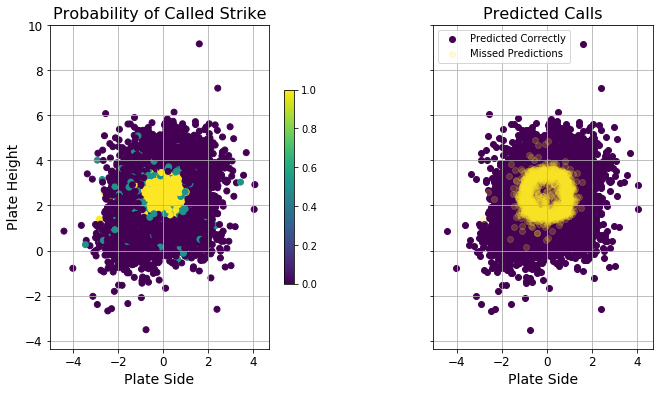

In [59]:
fig,ax = plt.subplots(1,2,sharey=True,sharex=True)
y_pp = knn_all_feat.predict_proba(X_te.to_numpy())
y_pred = knn_all_feat.predict(X_te.to_numpy())

im = ax[0].scatter(X_te.PlateSide,X_te.PlateHeight,c=y_pp[:,1],alpha=1.0)
# ax.figure.colorbar()

plt.colorbar(im,ax=ax[0],shrink=0.6,orientation='vertical',)
ax[0].set_xlabel('Plate Side',fontsize=14)
ax[0].set_ylabel('Plate Height',fontsize=14)
ax[0].set_title('Probability of Called Strike',fontsize=16)
ax[0].set_aspect('equal','box')
ax[0].tick_params(labelsize=12)
ax[0].grid(True)

ax[1].scatter(X_te.PlateSide[y_pred==y_te],X_te.PlateHeight[y_pred==y_te],c='#440154',alpha=1.0,label='Predicted Correctly')
ax[1].scatter(X_te.PlateSide[y_pred!=y_te],X_te.PlateHeight[y_pred!=y_te],c='#fde725',alpha=0.2,label='Missed Predictions')
ax[1].legend()
ax[1].set_xlabel('Plate Side',fontsize=14)
ax[1].set_aspect('equal')#,'box')
ax[1].set_title('Predicted Calls',fontsize=16)
ax[1].tick_params(labelsize=12)
ax[1].grid(True)

fig.set_figheight(12)
fig.set_figwidth(12)
fig.subplots_adjust(top=0.5)


In [60]:
fig.savefig('KNN_all_features.jpg',bbox_inches='tight')

The decision function isn't as clear of a strike zone as I'd like, especially on the left side of the figure.

In [61]:
def plot_decision_function(X, y, clf, ax, show_data=False):
    """Plot the decision function of the classifier and the original data"""
    plot_step = 0.02
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(yy, xx, Z, alpha=1.0,cmap='binary',)
    if show_data:
        y_pred = clf.predict(X)
        plt.scatter(X[:,1][y_te == True],X[:,0][y_te == True],linewidths=1,marker='o',s=1,c='#fde725',alpha=0.4,label='Called Strike')
        plt.scatter(X[:,1][y_te == False],X[:,0][y_te == False],linewidths=1,marker='o',s=1,c='#440154',alpha=0.4,label='Called Ball')
        ax.legend(facecolor='#ebebeb',markerscale=5.0)

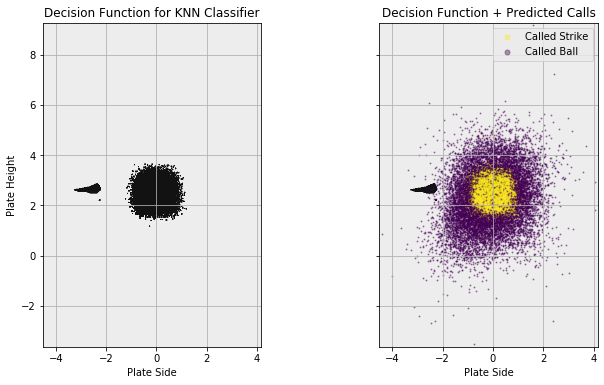

In [62]:
fig,ax = plt.subplots(1,2,sharey=True,sharex=True)
# plt.grid(True)

plot_decision_function(X_te[['PlateHeight','PlateSide']].to_numpy(),y_te.to_numpy(),knn_loc_only,ax[0])
plot_decision_function(X_te[['PlateHeight','PlateSide']].to_numpy(),y_te.to_numpy(),knn_loc_only,ax[1],True)

ax[0].set_aspect('equal','box')
ax[0].grid(True)
ax[1].set_aspect('equal','box')
ax[1].grid(True)
fig.set_figheight(12)
fig.set_figwidth(12)
ax[0].set_xlabel('Plate Side')
ax[1].set_xlabel('Plate Side')
ax[0].set_ylabel('Plate Height')
fig.subplots_adjust(top=.5,wspace=.01);
ax[0].set_title('Decision Function for KNN Classifier')
ax[1].set_title('Decision Function + Predicted Calls');



The decision function depends on the training data, so I wanted to see what was leading to the discrepencies in the strike zone from what I'd expected, particularly on the left side.

In [63]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, **kwargs):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, **kwargs)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))

    lim = (int(xymax/binwidth) + 1) * binwidth
    
    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins,**kwargs)
    ax_histy.hist(y, bins=bins, orientation='horizontal',**kwargs)
    ax_histx.set_facecolor('#d6d6d6')
    ax_histy.set_facecolor('#d6d6d6')

There are more called balls and strikes on the left side of center.

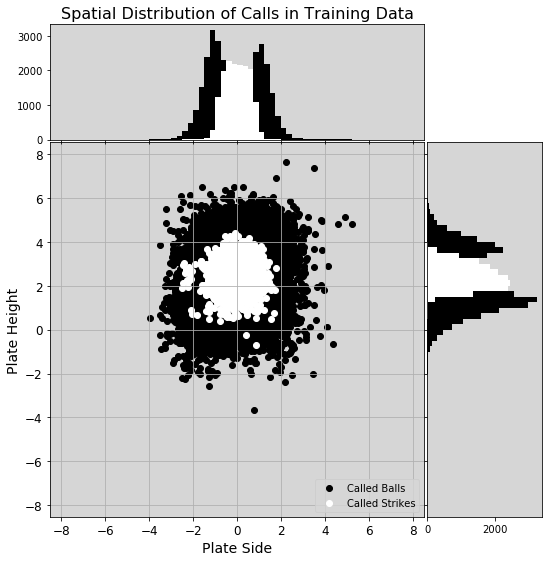

In [64]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

scatter_hist(X_tr['PlateSide'][y_tr == 0],X_tr['PlateHeight'][y_tr == 0],ax,ax_histx,ax_histy,color='#000000',label='Called Balls')
scatter_hist(X_tr['PlateSide'][y_tr == 1],X_tr['PlateHeight'][y_tr == 1],ax,ax_histx,ax_histy,color='#ffffff',label='Called Strikes')
ax.set_facecolor('#d6d6d6')
ax.legend(loc=4,facecolor='#d6d6d6')
ax.set_aspect('equal','box')
ax.grid(True)
ax.set_xlabel('Plate Side',fontsize=14)
ax.set_ylabel('Plate Height',fontsize=14)
ax.tick_params(labelsize=12)
ax_histx.set_title('Spatial Distribution of Calls in Training Data',fontsize=16,loc='center');


In [65]:
fig.savefig('Training_data_distrib.jpg',bbox_inches='tight')

Made the same figure again with the resampled data.

In [66]:
X_tr.columns

Index(['Balls', 'Strikes', 'PlateHeight', 'PlateSide', 'dummy_PitcherRighty',
       'dummy_BatterRighty', 'same_handedness'],
      dtype='object')

In [92]:
def scatter_hist_sc(x, y, ax, ax_histx, ax_histy, **kwargs):
    '''adjusted for use with MinMaxScaler output'''
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, **kwargs)

    # now determine nice limits by hand:
    binwidth = 0.02
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))

    lim = (int(xymax/binwidth) + 1) * binwidth
    
    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins,**kwargs)
    ax_histy.hist(y, bins=bins, orientation='horizontal',**kwargs)
    ax_histx.set_facecolor('#d6d6d6')
    ax_histy.set_facecolor('#d6d6d6')

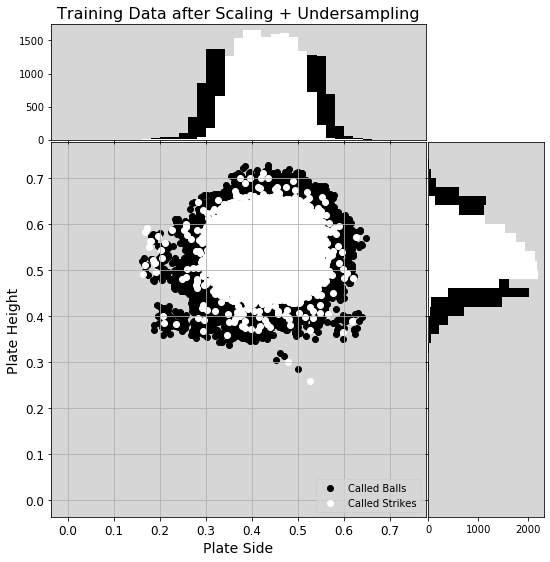

In [95]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

X_tr_rs= knn_all_feat['minmaxscaler'].transform(X_tr)
X_tr_rs,y_tr_rs = knn_all_feat['nearmiss'].fit_resample(X_tr_rs,y_tr)
scatter_hist_sc(X_tr_rs[:,3][y_tr_rs == 0],X_tr_rs[:,2][y_tr_rs == 0],ax,ax_histx,ax_histy,color='#000000',label='Called Balls')
scatter_hist_sc(X_tr_rs[:,3][y_tr_rs == 1],X_tr_rs[:,2][y_tr_rs == 1],ax,ax_histx,ax_histy,color='#ffffff',label='Called Strikes')
ax.set_facecolor('#d6d6d6')
ax.legend(loc=4,facecolor='#d6d6d6')
ax.set_aspect('equal','box')
ax.grid(True)
ax.set_xlabel('Plate Side',fontsize=14)
ax.set_ylabel('Plate Height',fontsize=14)
ax.tick_params(labelsize=12)
ax_histx.set_title('Training Data after Scaling + Undersampling',fontsize=16);

In [96]:
fig.savefig('NM1_resampled_training_data_distrib.jpg',bbox_inches='tight')

Even without optimizing for accuracy, I still managed decently high accuracy scores.

In [105]:
y_pred = knn_all_feat.predict(X_te)
accuracy_score(y_te,y_pred)

0.8745800671892497

In [106]:
y_pred = knn_loc_only.predict(X_te[['PlateHeight','PlateSide']])
accuracy_score(y_te,y_pred)

0.8761798112302032